In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs109b_hw3.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 

## Homework 3: Artificial Neural Networks, Model Interpretation, and Regularization


**Harvard University**<br/>
**Spring 2024**<br/>
**Instructors**: Pavlos Protopapas & Alex Young

<hr style="height:2pt">

In [2]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
).text
HTML(styles)

In [3]:
import random
random.seed(109)

import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# TensorFlow and tf.keras
import tensorflow as tf

In [4]:
# measure notebook runtime
time_start = time.time()

<div style = "background: lightsalmon; border: thin solid black; border-radius: 2px; padding: 5px">

### Instructions
- To submit your notebook, follow the instructions given in on the Canvas assignment page.
- Plots should be legible and interpretable *without having to refer to the code that generated them*. They should includelabels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you believe the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so simply passing all tests may not be sufficient for full credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**
</div>

<a id="contents"></a>

# Notebook Contents

- [**PART 1 [50 pts]: Modeling and predictive intervals in ANNs**](#part1)
  - [Overview and Data Description](#part1intro)
  - [Questions](#part1questions)


- [**PART 2 [50 pts]: Kannada MNIST Kaggle competition**](#part2)
  - [Problem Statement](#part2intro)
  - [The Kannada MNIST Dataset](#part2about)
  - [Downloading the Data Files](#part2data)
  - [CS109B Kaggle Competition](#part2kaggle)
  - [Questions](#part2questions)


<a id="part1"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 1 [50 pts]: Model interpretation and predictive intervals in ANNs

[Return to contents](#contents)

<a id="part1intro"></a>

## Overview and Data Description

[Return to contents](#contents)

In this problem, you will be building and interpreting models to predict whether a flight was delayed for its arrival. The model will be based on features that can be measured as the flight takes off.

We will also estimate the predictive intervals of the model using bootstrapping. We will utilize those predictive intervals to build a new kind of model: a model that refrains from making a prediction when it is not confident.

The variable in the original csv are:

    
**ARRIVAL_DELAY**: the difference between scheduled arrival and actual arrival, in minutes (positive is late, negative is early).

**DISTANCE**: the distance between arrival and departure airports, in miles.

**SCHEDULED_TIME**: the flight's scheduled travel time in minutes.

**MONTH**: the month the flight took off, 1 = January, 2 = February, etc.

**SCHED_DEP_HOUR**: the scheduled departure time (the hour of the day).

**SCHED_ARR_HOUR**: the scheduled arrival time (the hour of the day).

**FLIGHT_COUNT**: the number of flights flying out of the origin airport before noon on a typical day.

**DAY_OF_WEEK**: the day of the week, 1 = Monday, 2 = Tuesday, etc.

**ORIGIN_AIRPORT**: the airport the flight took off from.

**DESTINATION_AIRPORT**: the airport the flight was scheduled to land at.

For the airport codes, see: https://www.bts.gov/topics/airlines-and-airports/world-airport-codes

To sucessfully complete this part, you will proceed by fitting a NN model, evaluating its accuracy, interpreting the predictors' importance, and finally evaluating the predictive intervals.

**NOTE:** the observations were sampled so that roughly half of the observations were delayed and half of the observations were not delayed.

<!-- </div> -->

<a id="part1solutions"></a>

## PART 1 Questions

[Return to contents](#contents)


<div class='exercise-r'>

**1.1**  **Preprocess the data**

**Note that this part (section 1.1) has been completed for you. Simply run the provided cells below to load and preprocess the data. While you do not need to write any code here, you are expected to read through the processing steps taken here so that you fully understand the data you'll be working with.**


</div>

<div class='exercise-r'>

**1.1.1**   Read in the dataset `data/flights.csv` into a DataFrame called `df_flights`. Create a new column in the DataFrame called `DELAY_OR_NOT`. This is a binary variable that denotes whether `ARRIVAL_DELAY` is greater-than-or-equal-to 15 minutes (the FAA and BTS define a flight as delayed by 15 minutes or more). This is going to be the response variable for the rest of part 1. 




</div>

In [5]:
df_flights = pd.read_csv("data/flights.csv")
df_flights.info()
df_flights.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ARRIVAL_DELAY        10000 non-null  int64  
 1   DISTANCE             9995 non-null   float64
 2   SCHEDULED_TIME       9999 non-null   float64
 3   MONTH                10000 non-null  int64  
 4   SCHED_DEP_HOUR       10000 non-null  int64  
 5   SCHED_ARR_HOUR       10000 non-null  int64  
 6   FLIGHT_COUNT         9995 non-null   float64
 7   DAY_OF_WEEK          10000 non-null  int64  
 8   ORIGIN_AIRPORT       10000 non-null  object 
 9   DESTINATION_AIRPORT  10000 non-null  object 
dtypes: float64(3), int64(5), object(2)
memory usage: 781.4+ KB


,ARRIVAL_DELAY,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT
0,23,2586.0,342.0,9,7,15,240.0,3,SFO,JFK
1,10,1235.0,185.0,5,6,11,366.0,4,LAX,DFW
2,-7,184.0,76.0,4,17,18,172.0,7,BOS,LGA
3,68,862.0,148.0,7,19,21,260.0,7,IAH,DEN
4,24,236.0,71.0,3,20,21,266.0,2,LAS,LAX


In [6]:
df_flights["DELAY_OR_NOT"] = (df_flights["ARRIVAL_DELAY"] >= 15).astype(int)

delay_counts = df_flights["DELAY_OR_NOT"].value_counts().sort_index()

print(
    "The resulting counts for our \"DELAY_OR_NOT\" response variable,\n"
    "where class 1 are flights with actual arrivals 15 minutes late\n"
    "or later than scheduled, are:\n\n\tclass\tobservations"
)
for resp, value in zip(delay_counts.index, delay_counts.values):
    print("\t{}  \t{:,.0f}".format(resp, value))

The resulting counts for our "DELAY_OR_NOT" response variable,
where class 1 are flights with actual arrivals 15 minutes late
or later than scheduled, are:

	class	observations
	0  	5,069
	1  	4,931


<div class='exercise-r'>

**1.1.2 Preprocess the data**
    
- Deal with missing values if there are any
- One-hot-encode the non-numeric categorical variables
- Split the data using an 80/20 train-test split with `random_state=109` and stratifying on the response variable
- Standardize train and test with the scaler fit on the train data

Print the resulting shapes of your $X$ and $y$ dataframes for both your train and your test sets.
    
**NOTE:** While inspecting your data, you may notice that a large number of airport codes are recorded using 5-digit values instead of the expected 3-letter codes. That is perfectly fine. Those 5-digit values should be considered valid and just be treated the same as they would be if they were 3-letter codes.

**TIPS:** 
- month and day-of-the-week should be treated as numerical in this context.
- you should consider what predctors are acceptable to include given our goal is to predict if a flight is delayed.


</div>

In [7]:
# By displaying rows with missing values, we can see
# that ALL missing values occur for flights between
# BOS and SFO. This would indicate that these values are NOT
# missing at random. Therefore, we will want to impute our
# values rather than simply delete these rows
print("ALL MISSING VALUE ROWS, THEY APPEAR TO BE BSO TO SFO FLIGHTS:")
display(df_flights[df_flights.isnull().any(axis=1)])

# The next thing we will do is display all BOS to SFO observations
# to determine how we should treat missing values in each
# predictor column.
print(
    "\nALL BOS TO SFO FLIGHT OBSERVATIONS (INCLD. THOSE WITH MISSINGNESS):"
)
loc_filter = (df_flights["ORIGIN_AIRPORT"] == "BOS") & (df_flights["DESTINATION_AIRPORT"] == "SFO")
display(df_flights.loc[loc_filter])

# We can see that we know the exact values to enter for missing
# DISTANCE and missing FLIGHT_COUNT values, so rather than
# impute, we can just explicilty set the values as such, being
# certain to fix the column dtypes as well
df_flights["DISTANCE"] = df_flights["DISTANCE"].fillna(2704).astype(int)
df_flights["FLIGHT_COUNT"] = df_flights["FLIGHT_COUNT"].fillna(172).astype(int)

# As for the one missing SCHEDULED_TIME value, we could do
# something more involved like creating some sort of imputation model
# (such as trying to predict that one value using kNN), but because it's only
# one value and there does not appear to be much variability in time among
# the flights between BOS and SFO, we can probably just get away with populating
# this cell with the mean SCHEDULED_TIME for all flights between BOS and SFO
mean_time = df_flights.loc[loc_filter]["SCHEDULED_TIME"].mean()
df_flights["SCHEDULED_TIME"] = df_flights["SCHEDULED_TIME"].fillna(mean_time).astype(int)

# To wrap up, we'll print the df_flights info again to confirm no more
# missing values exist
print("\nTHE df_flights DATAFRAME AFTER RESOLVING MISSINGNESS:\n")
display(df_flights.info())

ALL MISSING VALUE ROWS, THEY APPEAR TO BE BSO TO SFO FLIGHTS:


,ARRIVAL_DELAY,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DELAY_OR_NOT
70,13,NaN,395.0,11,6,9,NaN,1,BOS,SFO,0
1566,-4,NaN,418.0,2,6,9,NaN,5,BOS,SFO,0
3741,-33,NaN,419.0,11,11,15,NaN,2,BOS,SFO,0
5612,-9,NaN,381.0,6,8,12,NaN,5,BOS,SFO,0
6375,17,NaN,NaN,7,18,21,NaN,3,BOS,SFO,1



ALL BOS TO SFO FLIGHT OBSERVATIONS (INCLD. THOSE WITH MISSINGNESS):


,ARRIVAL_DELAY,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DELAY_OR_NOT
70,13,NaN,395.0,11,6,9,NaN,1,BOS,SFO,0
155,-17,2704.0,390.0,8,7,10,172.0,6,BOS,SFO,0
1566,-4,NaN,418.0,2,6,9,NaN,5,BOS,SFO,0
1729,16,2704.0,390.0,9,20,23,172.0,1,BOS,SFO,1
2775,-9,2704.0,403.0,3,11,14,172.0,1,BOS,SFO,0
3132,101,2704.0,412.0,2,16,20,172.0,4,BOS,SFO,1
3741,-33,NaN,419.0,11,11,15,NaN,2,BOS,SFO,0
5612,-9,NaN,381.0,6,8,12,NaN,5,BOS,SFO,0
5929,-5,2704.0,404.0,3,6,9,172.0,1,BOS,SFO,0
6375,17,NaN,NaN,7,18,21,NaN,3,BOS,SFO,1



THE df_flights DATAFRAME AFTER RESOLVING MISSINGNESS:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ARRIVAL_DELAY        10000 non-null  int64 
 1   DISTANCE             10000 non-null  int64 
 2   SCHEDULED_TIME       10000 non-null  int64 
 3   MONTH                10000 non-null  int64 
 4   SCHED_DEP_HOUR       10000 non-null  int64 
 5   SCHED_ARR_HOUR       10000 non-null  int64 
 6   FLIGHT_COUNT         10000 non-null  int64 
 7   DAY_OF_WEEK          10000 non-null  int64 
 8   ORIGIN_AIRPORT       10000 non-null  object
 9   DESTINATION_AIRPORT  10000 non-null  object
 10  DELAY_OR_NOT         10000 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 859.5+ KB


None

In [8]:
# identify our response variable
response = "DELAY_OR_NOT"

# identify categorical predictors for one-hot-encoding
cat_preds = ["ORIGIN_AIRPORT", "DESTINATION_AIRPORT"]

# identify columns we will need to drop from X after encoding 
drop_cols = ["ARRIVAL_DELAY", response] + cat_preds

# one-hot-encode and make certain to drop one col for each predictor
df_one_hot = pd.get_dummies(df_flights[cat_preds], drop_first=True)

# merge encoded columns with other predictor columns to create
# our X data, being certain to drop non-predictor columns
X_flights = pd.concat(
    [
        df_flights.drop(columns=drop_cols),
        df_one_hot,
    ],
    axis=1,
)
y_flights = df_flights[response]

X_train, X_test, y_train, y_test = train_test_split(
    X_flights, y_flights, test_size=0.20, random_state=111, stratify=y_flights
)

# scale X data using standard scaler, and retain our original
# X dataframes so we can use them to plot data in its
# original scale for Q1.4 later in HW3
X_train_std = X_train.copy()
X_test_std = X_test.copy()

scaler = StandardScaler().fit(X_train)
X_train_std[X_train.columns] = scaler.transform(X_train)
X_test_std[X_test.columns] = scaler.transform(X_test)

# print our resulting X and y shapes
print(
    "The shapes of our resulting X and y train and test sets are:\n\n"
    "\tX_train\t{}\n\ty_train\t{}\n\n\tX_test\t{}\n\ty_test\t{}\n"
    .format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape,
    )
)

The shapes of our resulting X and y train and test sets are:

	X_train	(8000, 808)
	y_train	(8000,)

	X_test	(2000, 808)
	y_test	(2000,)



<div class='exercise-r'>

**1.2**  **Fit an ANN**

Fit an artificial neural network model using all predictors (name this model `NN_model`).  Use a dense feed-forward network with two hidden layers with 15 nodes in each hidden layer. For this network, use a reasonable activation functions for the hidden layers and output, select an appropriate loss function and optimizer, specify a validation split of 0.2, and train for a reasonable number of epochs and batch size of your choice. Plot the training accuracy and validation accuracy as a function of epochs from your `NN_model`'s training history. Evaluate the `NN_model` model on both train and test, and print out the resulting train and test accuracies.

You should base your choice of "a reasonable number of epochs" on a visualization of the model's training history.

<a id="q12"></a>



</div>

In [9]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

In [10]:
# build your NN 
# your code here

NN_model = models.Sequential([
    layers.Dense(15, activation='relu', input_shape=(X_train_std.shape[1],)),
    layers.Dense(15, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [11]:
# compile it and run it
# your code here 

NN_model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
history = NN_model.fit(X_train_std, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

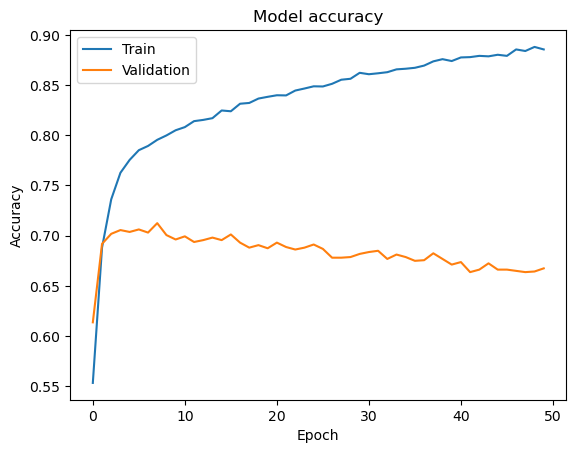

In [12]:
# plot train and val acc as a function of epochs
# your code here
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [13]:
# evaluate on train and test and print accuracy results
# your code here 

# train dataset
train_loss, train_accuracy = NN_model.evaluate(X_train_std, y_train, verbose=0)

# test dataset
test_loss, test_accuracy = NN_model.evaluate(X_test_std, y_test, verbose=0)

# printing train an d test accuracy
print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


Train Accuracy: 0.8561
Test Accuracy: 0.6560


<div class='exercise-r'>

**1.3**  **Bootstrap prediction intervals**

In HW2, we saw how we could use MCMC to perform Bayesian inference on the parameters of a logistic regression model. This gave us access not only to samples from the posterior distribution (betas) but we could also generate samples from the posterior predictive distribution (data). The posterior predictive can be used to represent our uncertainy about a given prediction, $\hat{y}$.

We'd like to do something similar for our neural network here so that we can quantify the uncertainty in our predictions. But there are some problems. First, we haven't (explicitly) specified any priors on the network weights. Second, and more serious, neural networks have many, many parameters. Far too many for MCMC to be a viable approach. Sampling in such a high dimensional space is simply intractable.

Bootstrap to the rescue!

Using the same network architecture as `NN_model` (layers, nodes, activations, etc.) and your scaled data from that model, create multiple training sets using bootstrapping and fit a separate neural network model to each bootstrapped set of data (the number of bootstraped *datasets*, $n$, should be at least 50). For each of the $n$ models, make predictions on the test data. Randomly select 8 test observations and on 8 subplots, plot the distribution of the $n$ predicted probabilities with the 95% prediction intervals clearly marked and reported in each subplot and the **actual** class of each observation included in each subplot's title for easy reference.
    
Interpret what you see in 3-5 sentences.

**NOTE:** The code for this problem can take an extremely long time to execute. Please feel free to use the `progressbar` function provided below to visually track the progress of your bootstraps.

<a id="q13"></a>


</div>

In [14]:
def progressbar(n_step, n_total):
    """Prints self-updating progress bar to stdout to track for-loop progress
    
    There are entire 3rd-party libraries dedicated to custom progress-bars.
    A simple function like this is often more than enough to get the job done.
    
    :param n_total: total number of expected for-loop iterations
    :type n_total: int
    :param n_step: current iteration number, starting at 0
    :type n_step: int

    .. example::
    
        for i in range(n_iterations):
            progressbar(i, n_iterations)
            
    .. source:
    
        This function is a simplified version of code found here:
        https://stackoverflow.com/questions/3160699/python-progress-bar/15860757#15860757
    """
    n_step = n_step + 1
    barlen = 50
    progress = n_step / n_total
    block = int(round(barlen * progress))
    status = ""
    if n_step == n_total:
        status = "Done...\r\n\n"
    text = "\r [{0}] {1}/{2} {3}".format(
        "=" * block + "-" * (barlen - block),
        n_step,
        n_total,
        status,
    )
    sys.stdout.write(text)
    sys.stdout.flush()

In [17]:
%%time
# Bootstrap and train your networks and get predictions on X test
# your code here

# function to build NN
def build_NN(name='NN', input_shape=(1,), hidden_dims=[2], hidden_act='relu', out_dim=1, out_act='linear'):
    model = models.Sequential(name=name)
    model.add(layers.Input(shape=input_shape))
    for hidden_dim in hidden_dims:
        model.add(layers.Dense(hidden_dim, activation=hidden_act))
    model.add(layers.Dense(out_dim, activation=out_act))
    return model

# function to get predictions
def get_bagged_pred(bagged_model, X): 
    n_obs = X.shape[0]
    pred_dim = bagged_model[0].layers[-1].output_shape[-1]
    n_models = len(bagged_model)
    boot_preds = np.zeros((n_obs, pred_dim, n_models))
    for i, model in enumerate(bagged_model):
        boot_preds[:,:,i] = model.predict(X)
    bag_pred = boot_preds.mean(axis=-1)
    return bag_pred, boot_preds

n_bootstrap = 50
bagged_model = []

for i in range(n_bootstrap):
    indices = np.random.randint(0, X_train_std.shape[0], X_train_std.shape[0])
    X_train_bootstrap = X_train.iloc[indices].astype(np.float32)
    y_train_bootstrap = y_train.iloc[indices].astype(np.float32)
    
    model = build_NN(input_shape=X_train_std.shape[1:], hidden_dims=[15, 15], hidden_act='relu', out_dim=1, out_act='sigmoid')
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_bootstrap, y_train_bootstrap, epochs=50, batch_size=32, verbose=0)
    
    bagged_model.append(model)
    
bag_pred, boot_preds = get_bagged_pred(bagged_model, X_test_std)

# Select 8 random test observations for plotting
selected_indices = np.random.choice(X_test.shape[0], 8, replace=False)


63/63 [==============================] - 0s 632us/step
CPU times: user 10min 15s, sys: 2min 6s, total: 12min 22s
Wall time: 8min 13s


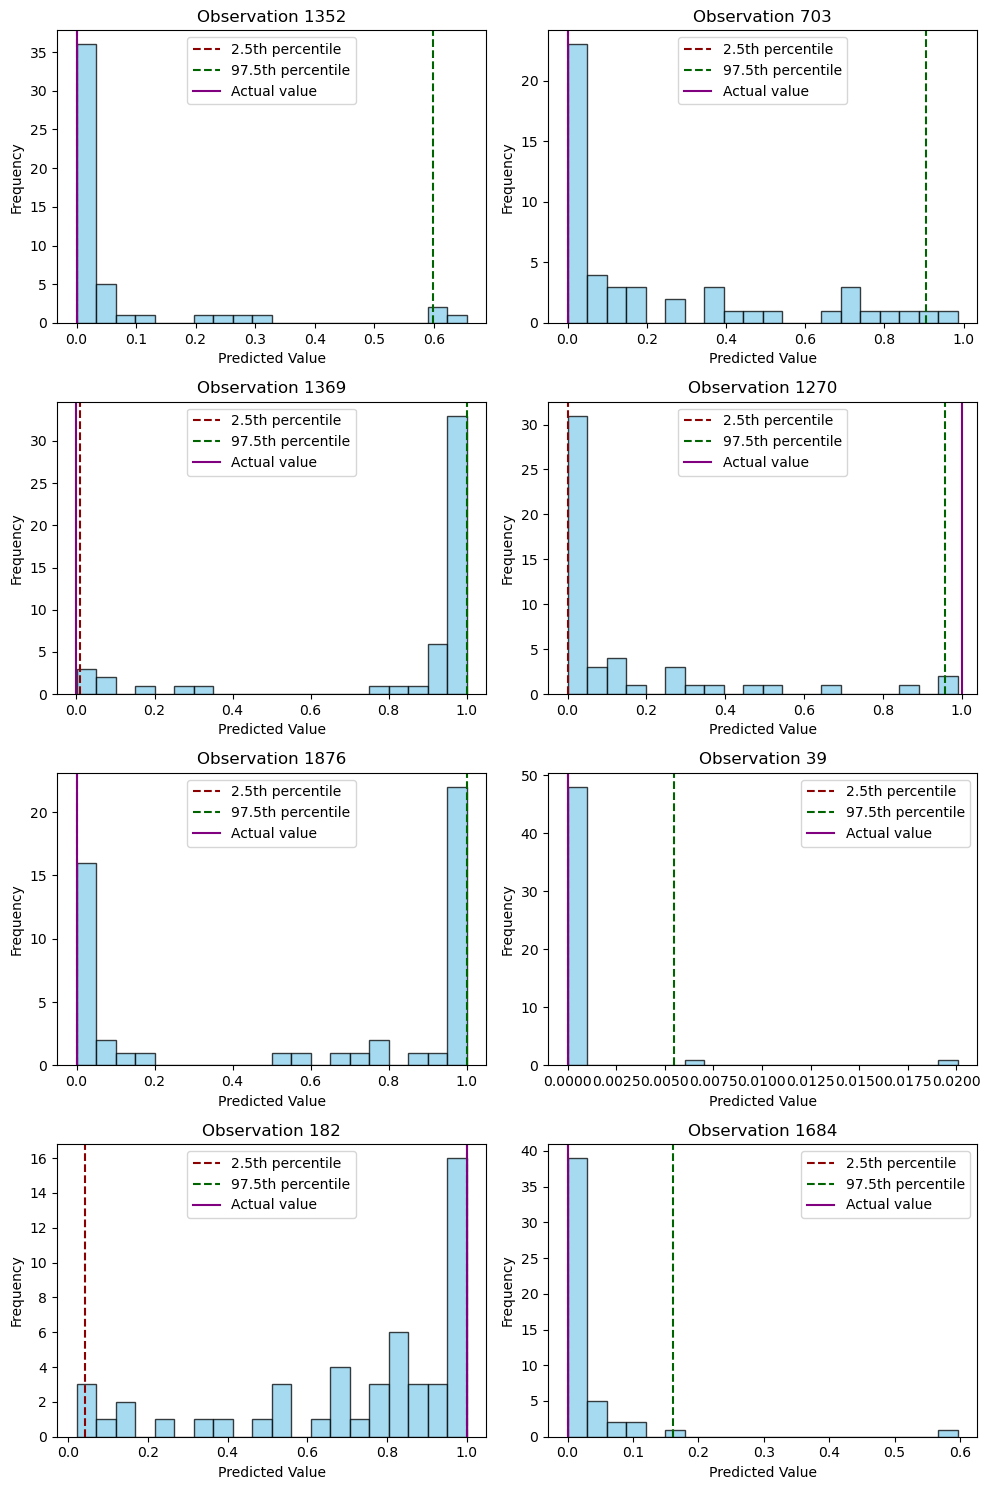

In [21]:
# generate your plot
# your code here

fig, axes = plt.subplots(4, 2, figsize=(10, 15))
axes = axes.ravel()

for i, index in enumerate(selected_indices):
    preds = boot_preds[index, 0, :]
    
    axes[i].hist(preds, bins=20, alpha=0.75, color='skyblue', edgecolor='black')
    
    axes[i].axvline(x=lower_bounds[index, 0], color='darkred', linestyle='--', label='2.5th percentile')
    axes[i].axvline(x=upper_bounds[index, 0], color='darkgreen', linestyle='--', label='97.5th percentile')
    
    actual_value = y_test.iloc[index]
    axes[i].axvline(x=actual_value, color='purple', linestyle='-', label='Actual value')
    
    axes[i].set_title(f'Observation {index}')
    axes[i].set_xlabel('Predicted Value')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

plt.tight_layout()
plt.show()


<ADD INTERPRETATION>

<div class='exercise-r'>

**1.4**  **Build an "abstain" bagging model**

Using the probability distribution of the predictions obtained from the bootstrapped samples above, we can evaluate how confident we should be in our bagged (i.e. bootstrap-aggregated) predictions for each test observation.

To accomplish this, you will first calculate a metric we'll call the **Posterior Prediction Dissent (PPD)** related to the proportion of predictions a given test observation receives for the minority opinion. Some examples: if 10% of the bootstrapped models predict $\hat{y} = 0$ with the remaining 90% predicting $\hat{y}=1$, then the $PPD=0.1$. When a bagged prediction's $PPD=0$, all predictions are compatible (i.e. all bootstrapped probabilities for that test observation are on the same side of $\hat{p}=0.5$). Likewise, when the $PPD=0.5$, half of the bootstrapped predictions for that test observation are $\hat{y}=0$, and the other half are $\hat{y}=1$. After calculating your $PPD$ values for all test observations, you should have $n=2000$ $PPD$ values (i.e. one for each test observation).

Next, to get more accurate predictions, we can create an **abstain** model that will abstain from making a prediction for a particular observation if some defined threshold for lack-of-confidence (i.e. maximum permissible $PPD$ value) is crossed. (If you'd like to learn more about abstain models, you can read more [here](https://openreview.net/forum?id=rJxF73R9tX).)

Let's explore how your resulting test accuracies might change by using your bootstrapped prediction results from question 1.5 for an **abstain bagging model** (i.e. a bootstrap aggregated model where some test observations are simply not predicted based on a given $PPD$ threshold). You can make your abstain model *stricter* by using smaller $PPD$ threshold values.

- Print the test accuracy for your **bagging model** predictions from question 1.5 using predictions for all 2,000 of our test observations. 

- Plot the test accuracies for an **abstain bagging model** using your predictions from question 1.5 as a function of increasing $PPD$.

- Also, plot the proportion of test observations not abstained (i.e. the proportion of those predicted) for your **abstain bagging model** as a function of increasing $PPD$.

- Interpret what you see in 3-5 sentences.

**NOTE**: You should observe that as $PPD$ decreases (more confident predictions), you must also compromise on the number of points that your abstain model is permitted to predict on. 

**HINT:** 
- What is the range of values PPD can take on? Is it the same as the range of our predictions themselves?
- When calculating accuracies, you should only consider those observations that received predictions (i.e., not the abstained observations)
</div>

In [27]:
# your code here

# PPD values
minority_preds = np.minimum(boot_preds.mean(axis=-1), 1 - boot_preds.mean(axis=-1))

len(minority_preds)

2000

In [28]:
# your code here

# abstain model
thresholds = np.linspace(0, 0.5, 50)
accuracies = []
proportions = []

for threshold in thresholds:
    abstain = minority_preds >= threshold
    if np.any(~abstain):
        predicted_labels = (boot_preds.mean(axis=-1) >= 0.5).astype(int)[~abstain]
        true_labels = y_test.iloc[~abstain].values
        accuracy = accuracy_score(true_labels, predicted_labels)
        accuracies.append(accuracy)
        proportions.append(np.mean(~abstain))
    else:
        accuracies.append(None)
        proportions.append(0)

In [29]:
# test accuracy for bagging predictions

mean_predictions = boot_preds.mean(axis=-1).squeeze()

predicted_classes = (mean_predictions >= 0.5).astype(int)

test_accuracy = accuracy_score(y_test, predicted_classes)

print(f"Test accuracy for the bagging model: {test_accuracy}")

Test accuracy for the bagging model: 0.5935


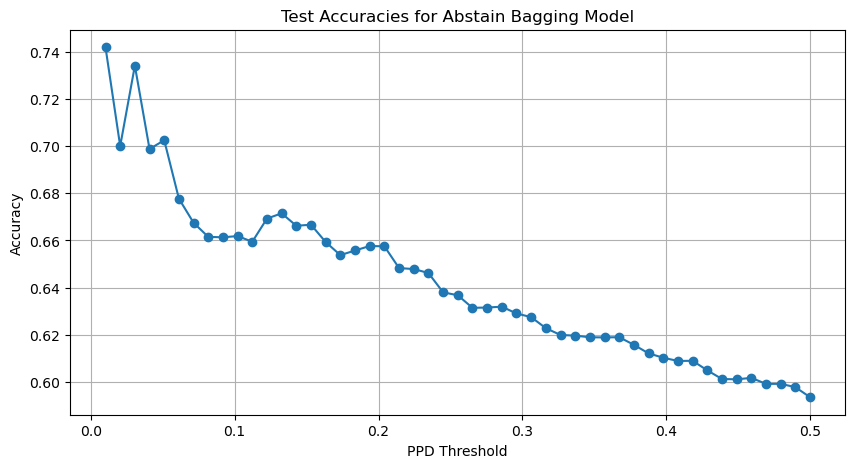

In [30]:
# your code here
# test accuracies for the abstain bagging model
plt.figure(figsize=(10, 5))
plt.plot(thresholds, accuracies, marker='o')
plt.title('Test Accuracies for Abstain Bagging Model')
plt.xlabel('PPD Threshold')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


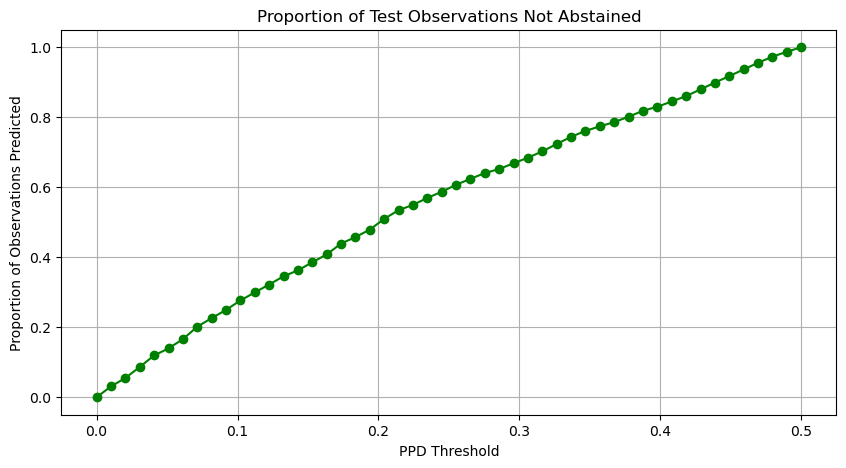

In [31]:
# test observations not abstained

plt.figure(figsize=(10, 5))
plt.plot(thresholds, proportions, marker='o', color='green')
plt.title('Proportion of Test Observations Not Abstained')
plt.xlabel('PPD Threshold')
plt.ylabel('Proportion of Observations Predicted')
plt.grid(True)
plt.show()

<ADD INTERPRETATION>

<a id="part2"></a>

<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 2 [50 pts]: Kannada MNIST Kaggle competition

[Return to contents](#contents)


<a id="part2intro"></a>

## Problem Statement

[Return to contents](#contents)


Artificial neural networks (ANNs) can be prone to overfitting, where they learn specific patterns present in the training data, but the patterns do not generalize to new data.

There are several methods used to improve ANN generalization. 

One approach is to use an architecture just barely wide or deep enough to fit the data. The idea here is that smaller networks are less expressive and thus less able to overfit the data.

However, it is difficult to know a priori the correct size of the ANN, and it is computationally costly to hunt for the correct size. Given this, other methodologies are used to prevent overfitting and improve ANNs' generalizability. These methodologies, like other techniques that combat overfitting, fall under the umbrella term of "regularization".

In this problem, you are asked to regularize a network of a given architecture.

<a id="part2about"></a>

## The Kannada MNIST Dataset

[Return to contents](#contents)


![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3630446%2F1e01bcc28b5ccb7ad38a4ffefb13cde0%2Fwondu.png?generation=1603204077179447&alt=media)


For this problem, we will be working with a modified version of the [Kannada MNIST dataset](https://arxiv.org/pdf/1908.01242.pdf), which is a large database of handwritten digits in the indigenous language *Kannada*.

This dataset consists of 60,000 28x28 grayscale images of the ten digits, along with a test set of 10,000 images. 

For this homework, we will simplify the problem by only using the digits labeled `0` and `1` owing to the similarity of the two symbols, and we will use a total of 1,200 samples for training (this includes the data you will use for validation).

To understand the dataset better, we recommend this [article](https://towardsdatascience.com/a-new-handwritten-digits-dataset-in-ml-town-kannada-mnist-69df0f2d1456) by Vinay Prabhu, the curator of the dataset.

<a id="part2data"></a>

## Downloading the Data Files

[Return to contents](#contents)


**Please download the specific `kmnist_train.csv` and `kmnist_test.csv` data files available on [the "Data" tab of the CS109B HW3 Kaggle Competition website](https://www.kaggle.com/t/01aa5d4183fd4c429e4563808369b2a2). (DO NOT USE DATA FROM ANY OTHER SOURCE!)**

Here's a brief description of the data files:

- `kmnist_train.csv` is our training dataset and the last column contains our response class. The 784 other columns correspond to the pixel values of the 28x28 dimension image. Class 0 means a sample is the handwritten digit `0` and class 1 means a sample is the handwritten digit `1` in the Kannada written language. `kmnist_train.csv` has 1,200 samples.


- `kmnist_test.csv` has a structure similar to `kmnist_train.csv`, however the class label column is NOT included in with the test set. `kmnist_test.csv` has 2,000 samples. 


Kaggle leaderboard scores are accuracy scores calculated by Kaggle when you upload your predictions on this test set.

- `sample_submission.csv` is the format that kaggle will accept. The uploaded `.csv` must contain 2 columns. The first column must be named `id` and needs to contain the test observation index numbers for each prediction, the second must be named `category` and needs to contain your class predictions (i.e. `0` or `1`) for each corresponding test observation index location. 

<a id="part2kaggle"></a>

## CS109B Kaggle Competition

[Return to contents](#contents)

**ACCESS AND JOIN THE COMPETITION**:

**You need to create an account on Kaggle and [join the competition via this link](https://www.kaggle.com/t/01aa5d4183fd4c429e4563808369b2a2). This is a limited participation competition. Please DO NOT share this link.**

**For more information on the rules** governing this CS109B Kaggle competition, please see below and also review [the modelling restrictions DOS and DON'TS outlined in question 2.3.1](#q2.3.1).

**IMPORTANT NOTES ABOUT SCORING**:

- The **public leaderboard** on Kaggle displays your performance on only 30% of the test set.


- After the competition is complete, the **private leaderboard** will show your performance on the remaining 70% of the test set.

- Question 2.3.5 is worth 5 points (the entire notebook is scored out of 100). Points for this questions will be awarded based on the **private leaderboard** as follows.

|Private Leaderboard Score   | Points|
|----------------------------|-------|
|$0.945 \leq \text{score}$ |5|
|$0.944 \leq \text{score} \lt 0.945$|4|
|$0.93 \leq \text{score} \lt 0.94$|3|
|$0.92 \leq \text{score} \lt 0.93$|2|
|$0.889 \leq \text{score} \lt 0.92$|1|

**🏆 Grand Prize(s):** The **Top-4** students on the private leaderboard will win an invitation to dinner with Pavlos and some of the CS109B teaching staff. This refers to the top 4 individuals on the board. The invitation will be extended to 5 students if the restriction to 4 would otherwise divide a group (e.g., 3 single submissions at the top followed by a group of 2).

**ADDITIONAL COMPETITION RULES:**

- Multiple Kaggle submissions are permitted (with a maximum of 20 submissions per-participant per-day), **just note that you will need to choose, on Kaggle, the ONE single submission to use for final scoring prior to the final HW3 submission deadline**, and **your submitted notebook MUST contain the matching code and model that generated your ONE chosen submission.**


- **To repeat this point, the version of your final HW3 notebook submitted on Canvas MUST contain the same code and exact same model used to generate your ONE chosen Kaggle submission.** (TFs may rerun your notebook code to ensure comparable final leaderboard results.)


- **Please do not manually label your submissions.** In other words, the labels should only be the outcome of your model.


- **No external data are allowed, you MUST USE ONLY the KMNIST training and test data downloaded via the "Data" tab of [the CS109B competition page linked above](#part2data).**


- **Do not** create multiple accounts on Kaggle.


<div class='exercise-r'>

**2.1**  **Get and visualize the data**

- Download the train and test data from [the competition page](#part2data).
- We will utilize `kmnist_test.csv` in question 2.3.4 only. 
- Load the data and use the matplotlib function `imshow` to display a handwritten 0 and a handwritten 1 from the training set.
- You are responsible for any preprocessing you deem necessary to help in your prediction task.

<a id="q22"></a>



</div>

In [34]:
# your code here
kminst_test = pd.read_csv('data/kmnist_test.csv')
kminst_test.head()

,pixel 1,pixel 2,pixel 3,pixel 4,pixel 5,pixel 6,pixel 7,pixel 8,pixel 9,pixel 10,...,pixel 775,pixel 776,pixel 777,pixel 778,pixel 779,pixel 780,pixel 781,pixel 782,pixel 783,pixel 784
0,38.167092,38.167092,54.242517,82.402707,57.519895,38.167092,38.167092,38.167092,38.167092,83.975893,...,38.167092,38.167092,38.167092,38.167092,68.490056,60.846754,38.167092,38.167092,38.167092,38.167092
1,35.295784,21.289541,21.289541,35.614861,21.289541,21.289541,82.447909,21.289541,21.289541,21.289541,...,21.289541,21.289541,25.689617,21.289541,21.289541,21.289541,21.289541,21.289541,35.579927,21.289541
2,21.521684,21.521684,21.521684,21.521684,57.199072,21.521684,21.521684,83.038062,46.479759,64.182483,...,21.521684,21.521684,21.521684,58.240365,83.038062,43.627021,21.521684,21.521684,21.521684,21.521684
3,73.500705,17.146684,45.996388,17.146684,17.146684,17.146684,17.146684,17.146684,73.500705,25.910554,...,17.146684,17.146684,57.801082,17.146684,73.500705,17.146684,17.146684,17.146684,17.146684,17.146684
4,24.724490,24.724490,90.599163,24.724490,24.724490,24.724490,24.724490,53.192570,45.764022,57.982717,...,24.724490,24.724490,24.724490,87.932260,24.724490,24.724490,39.901236,90.599163,24.724490,24.724490


In [35]:
# your code here

row_0 = kminst_test[kminst_test.iloc[:, 0] == 0].iloc[0]
row_1 = kminst_test[kminst_test.iloc[:, 0] == 1].iloc[0]

# reshape and display images
image_0 = row_0.iloc[1:].values.reshape(28, 28).astype(np.uint8)
image_1 = row_1.iloc[1:].values.reshape(28, 28).astype(np.uint8)

IndexError: single positional indexer is out-of-bounds

<div class='exercise-r'>

**2.2**  **Overfit an ANN** 

Build and fit a fully-connected network (FCN) with the architecture given below using `tensorflow.keras` and assign it to a variable called `model_overfit`:

- Number of hidden layers: 3
- Nodes per hidden layer: 100, 100, 100
- Activation function: ReLU 
- Loss function: binary_crossentropy
- Output unit: Sigmoid 
- Optimizer: adam (use the defaults; no other tuning)
- Epochs: 1,000
- Batch size: 128
- Validation size: 0.3

![diagram](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3630446%2F6a491ff8d4ff590dc8ded9a25461cd4b%2FScreenshot%202020-10-20%20at%209.42.36%20PM.png?generation=1603210420701577&alt=media) 
    
This ANN, when trained on the dataset, will overfit to the training set. Plot the training accuracy and validation accuracy (the x-axis should represent the number of epochs, and the y-axis should represent the accuracy). Explain how you can tell the model is overfitting. 




</div>

In [ ]:
# your code here
...

In [ ]:
%%time 
# your code here
...

In [ ]:
# your code here
...

<div class='exercise-r'>

**2.3.1**  **Regularize the overfit network**

Create an ANN that doesn't overfit and use it to [compete on Kaggle](#part2kaggle).

<a id="q2.3.1"></a>
    
**DON'TS**

- **DO NOT change the architecture**. In other words, keep the same number of layers, same number of nodes, same activation function, and same loss function and output unit as was used in your question 2.2 overfit model. **No CNNs, RNNs, ensembles, or fancy enhancements.**

- **DO NOT manually label your submissions.** In other words, the labels should only be the outcome of your model.

- **DO NOT use any external data.** Please use ONLY the specific KMNIST datasets provided to you (via the CS109B [data link above](#part2data)) for training your model and for generating your test predictions.

**DOS**

 - **YOU CAN change the** number of epochs (max 2000), batch size, optimizer, and of course, add elements that can help to regularize your model (e.g., dropout, L2 norm, etc.).
 - **YOU CAN also** do data augmentation using the provided training data. 
 - **YOU CAN** add flatten layers as you see fit.

**IMPORTANT: YOU MUST** ensure that the version of the code and model in your final submitted notebook is the **EXACT SAME** code and model used to generate your Kaggle submission. TFs may run your submitted model to ensure comparable results. **Other Kaggle competition rules and scoring details [are listed here](#part2kaggle).**



</div>

In [ ]:
%%time
# your code here
...

In [ ]:
# your code here
...

In [ ]:
%%time 
# your code here
...

<div class='exercise-r'>

**2.3.2**  Plot your model's training accuracy and validation accuracy as a function of epochs.




</div>

In [ ]:
# your code here
...

<div class='exercise-r'>

**2.3.3**  In a few sentences, describe the various approaches you have taken to improve the performance of your regularized model in 2.3.1 as well as any observations you might have regarding your training and Kaggle results.


</div>

<div class='exercise-r'>

**2.3.4**  Generate your test-set class predictions using your regularized model. Save those predictions to a `.csv` formatted file. Submit that `.csv` file [to the CS109B Kaggle Competition](#part2kaggle) for leaderboard scoring. **IMPORTANT:** For Kaggle to accept and score your submitted `.csv` file, it MUST contain 2 columns. The first column must be named `"Id"` and needs to contain the test observation index numbers corresponding to each of your 2,000 predictions (index starting at `0`), the second column must be named `"Category"` and needs to contain your class predictions (i.e. `0` or `1`) for each corresponding test observation index location. Both columns should contain integer data types.




</div>

In [ ]:
# your code here
...

<div class='exercise-r'>

**2.3.5**  **Specify your Kaggle name that you have used on the leaderboard**. We CANNOT give you credit without this.

</div>

<!-- BEGIN QUESTION -->

<div class='exercise-r'><b>2.4 Wrap-up</b></div>

* In a few sentences, please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.

In [ ]:
hours_spent_on_hw = ...

In [ ]:
grader.check("q2.4")

In [ ]:
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for this notebook to run")

**This concludes HW3. Thank you!**